# 要素名

GRIB2 要素由三个数字 (GRIB Key) 确定：

- discipline
- parameterCategory
- parameterNumber

例如

| name | discipline | parameterCategory | parameterNumber |
|------|------------|-------------------|-----------------|
| temperature | 0          | 0                 | 0        |
| geopotential height | 0   | 3 | 5 |
| u component of wind | 0 | 2 | 2 |
| v component of wind | 0 | 2 | 3 |

更多要素编码可以参考 ECMWF 的 [Parameter Database](https://codes.ecmwf.int/grib/param-db/)。


`load_field_from_file()` 函数中的 `parameter` 参数支持字符串和字典两种格式。

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from reki.data_finder import find_local_file
from reki.format.grib.eccodes import load_field_from_file

In [2]:
start_time = pd.Timestamp.utcnow().floor(freq="D") - pd.Timedelta(days=2)
start_time_label = start_time.strftime("%Y%m%d%H")
forecast_time_label = "24h"
forecast_time = pd.to_timedelta(forecast_time_label)

gfs_grib2_orig_file_path = find_local_file(
    "cma_gfs_gmf/grib2/orig",
    start_time=start_time,
    forecast_time=forecast_time,
)
gfs_grib2_orig_file_path

PosixPath('/g3/COMMONDATA/OPER/CEMC/GFS_GMF/Prod-grib/2025070500/ORIG/gmf.gra.2025070500024.grb2')

## 字符串

`parameter` 参数可以指定作为要素场名的字符串，包括以下几种类型：

- ecCodes 支持的 `shortName` 要素名
- 内置的 WGRIB2 要素名
- 内置的 CEMC 要素名

### ecCodes shortName


GRIB2 是表格驱动的数据格式，数据文件中保存的元信息通常为数字形式，需要从数据文件之外的表格中查找数字对应的含义。
ecCodes 内置了一系列要素名，即 shortName，可以用来表示特定的要素场名称。

例如下面代码使用 `grib_ls` 命令列出 GRIB2 文件中的所有要素场信息，其中 `shortName` 可以作为 `parameter` 参数使用。

In [17]:
from IPython.utils.capture import capture_output

with capture_output() as captured:
    !module load eccodes/2.29.0/intel && grib_ls -P count "{gfs_grib2_orig_file_path}" 2>/dev/null | head -n 22

print(f"{captured.stdout}")

```bash
/g3/COMMONDATA/OPER/CEMC/GFS_GMF/Prod-grib/2025070500/ORIG/gmf.gra.2025070500024.grb2
count        edition      centre       date         dataType     gridType     typeOfLevel  level        stepRange    shortName    packingType  
1            2            babj         20250705     fc           regular_ll   surface      0            0-24         acpcp        grid_jpeg   
2            2            babj         20250705     fc           regular_ll   surface      0            0-24         ncpcp        grid_jpeg   
3            2            babj         20250705     fc           regular_ll   surface      0            0-24         unknown      grid_jpeg   
4            2            babj         20250705     fc           regular_ll   surface      0            0-24         asnow        grid_jpeg   
5            2            babj         20250705     fc           regular_ll   surface      0            24           t            grid_jpeg   
6            2            babj         20250705

```{note}
`unknown` 表示 ecCodes 无法识别该要素场，无法直接使用 shortName 来检索要素。
```

使用 ecCodes 的 shortName 可以用来检索要素场：

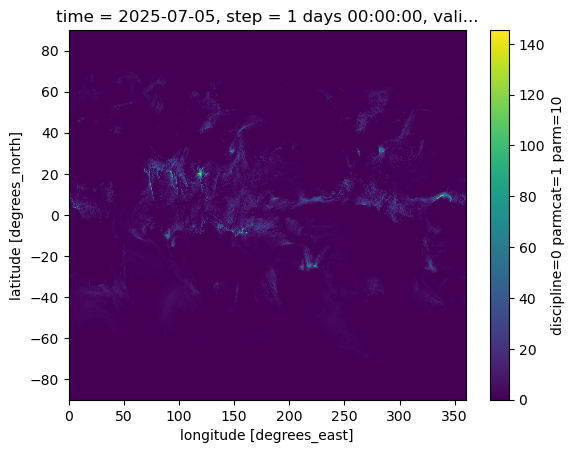

In [6]:
field = load_field_from_file(
    gfs_grib2_orig_file_path,
    parameter="acpcp",
)
field.plot()

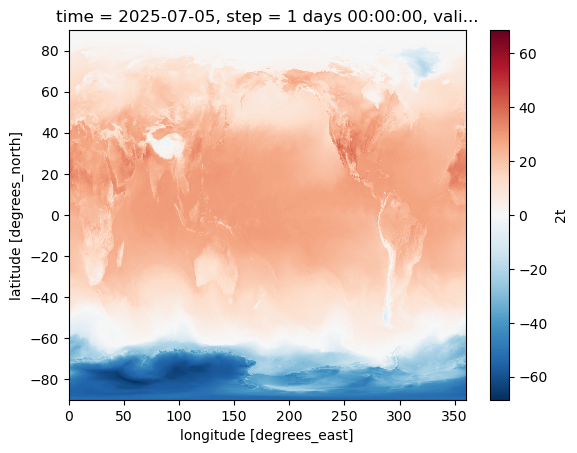

In [7]:
field = load_field_from_file(
    gfs_grib2_orig_file_path,
    parameter="2t",
) - 273.15
field.plot()


```{note}
ecCodes 的 shortName 和 ecCodes 本身的版本有关系，不同版本的 shortName 可能不同，使用时请额外注意。
```

### WGRIB2

reki 也内置了 WGRIB2 使用的要素表格，支持 WGRIB2 要素名。

wgrib2 命令会打印 GRIB2 文件中的要素清单。

In [14]:
with capture_output() as captured:
    !module load wgrib2/3.1.1/intel && wgrib2 "{gfs_grib2_orig_file_path}" 2>/dev/null | head -n 20

print(f"{captured.stdout}")

```bash
1:0:d=2025070500:ACPCP:surface:0-1 day acc fcst:
2:4375429:d=2025070500:NCPCP:surface:0-1 day acc fcst:
3:9751155:d=2025070500:APCP:surface:0-1 day acc fcst:
4:15683623:d=2025070500:ASNOW:surface:0-1 day acc fcst:
5:19246577:d=2025070500:TMP:surface:24 hour fcst:
6:21876436:d=2025070500:NLWRF:surface:0-1 day acc fcst:
7:26086847:d=2025070500:NSWRF:surface:0-1 day acc fcst:
8:30180484:d=2025070500:HFLUX:surface:0-1 day acc fcst:
9:32681484:d=2025070500:LHTFL:surface:0-1 day acc fcst:
10:36994040:d=2025070500:ULWRF:surface:0-1 day acc fcst:
11:40597876:d=2025070500:ULWRF:top of atmosphere:0-1 day acc fcst:
12:44565796:d=2025070500:DLWRFCS:surface:0-1 day acc fcst:
13:47279651:d=2025070500:var discipline=0 center=38 local_table=1 parmcat=5 parm=224:surface:0-1 day acc fcst:
14:50877303:d=2025070500:var discipline=0 center=38 local_table=1 parmcat=5 parm=224:top of atmosphere:0-1 day acc fcst:
15:53723970:d=2025070500:USWRF:surface:0-1 day acc fcst:
16:56801083:d=2025070500:NSWRF:t

使用 WGRIB2 要素名称加载要素场：

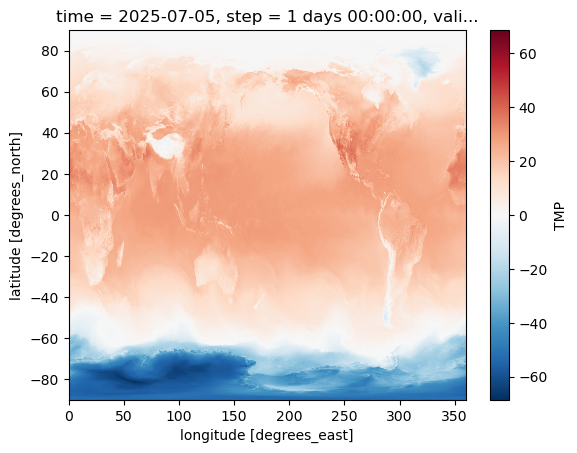

In [20]:
field = load_field_from_file(
    gfs_grib2_orig_file_path,
    parameter="TMP",
    level_type="heightAboveGround",
    level=2,
) - 273.15
field.plot()

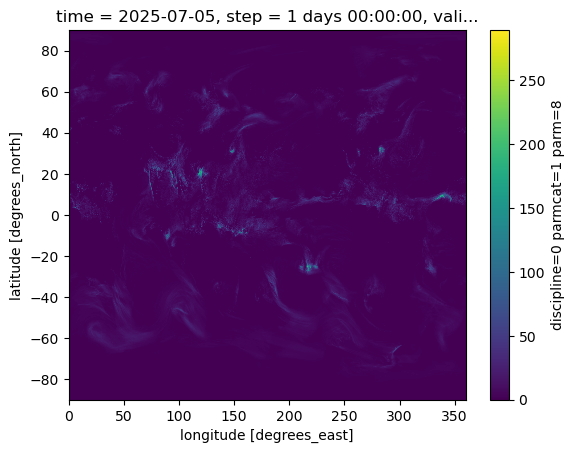

In [21]:
field = load_field_from_file(
    gfs_grib2_orig_file_path,
    parameter="APCP"
)
field.plot()

### CEMC要素清单

reki 内置了 CEMC 的要素清单，支持 CEMC 自定义的变量名。

In [25]:
from reki.format.grib.config import CEMC_PARAM_TABLE

CEMC_PARAM_TABLE.head(n=10)

,name,unit,description,description_cn,discipline,category,number,typeOfLevel,level,first_level_type,first_level,second_level_type,second_level,stepType,alias
0,ps,Pa,Surface pressure,地面气压,0.0,3.0,0.0,surface,NaN,1.0,NaN,NaN,NaN,NaN,False
1,psfc,Pa,Surface pressure,地面气压,0.0,3.0,0.0,surface,NaN,1.0,NaN,NaN,NaN,NaN,True
2,psl,Pa,Sea level pressure,海平面气压,0.0,3.0,1.0,meanSea,NaN,101.0,NaN,NaN,NaN,NaN,False
3,pi,NaN,Exner pressure,Exner气压,0.0,3.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,h,Gpm,Geopotential height,位势高度,0.0,3.0,5.0,NaN,NaN,100.0,NaN,NaN,NaN,NaN,False
5,zs,Gpm,Terrain,地形高度,0.0,3.0,5.0,surface,NaN,1.0,NaN,NaN,NaN,NaN,False
6,t,K,Temperature,温度,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
7,t2m,K,Temperature at 2 meters height,2米温度,0.0,0.0,0.0,heightAboveGround,2.0,103.0,2.0,NaN,NaN,NaN,False
8,ts,K,Surface temperature,地面温度,0.0,0.0,0.0,surface,NaN,1.0,NaN,NaN,NaN,NaN,False
9,tsfc,K,Surface temperature,地面温度,0.0,0.0,0.0,surface,NaN,1.0,NaN,NaN,NaN,NaN,True


使用 CEMC 要素名可以方便地加载一些 CEMC 定义的变量。
下面代码加载辐射亮温（红外通道）要素场：

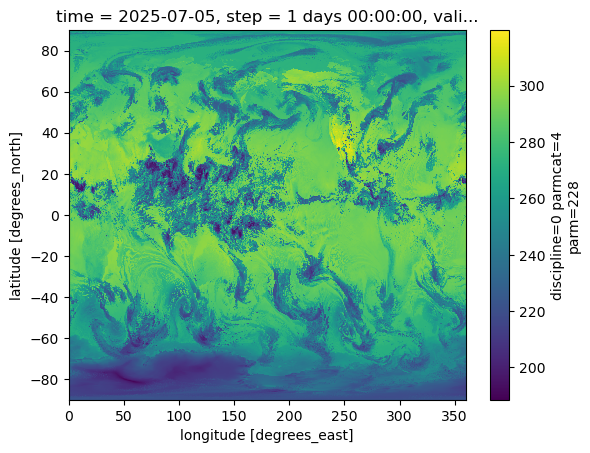

In [26]:
field = load_field_from_file(
    gfs_grib2_orig_file_path,
    parameter="bti"
)
field.plot()

加载 2 米温度场

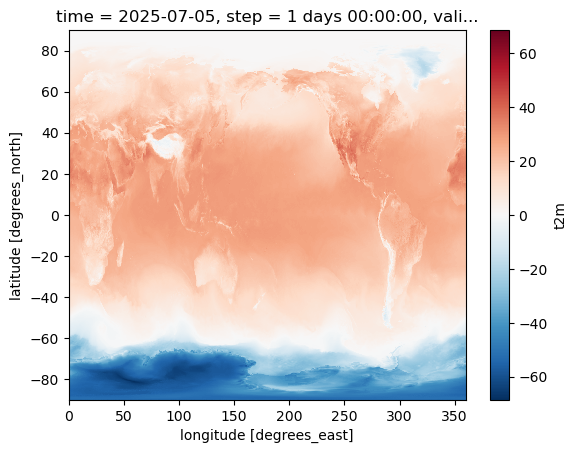

In [27]:
field = load_field_from_file(
    gfs_grib2_orig_file_path,
    parameter="t2m"
) - 273.15
field.plot()

加载 0-3km 垂直风切变

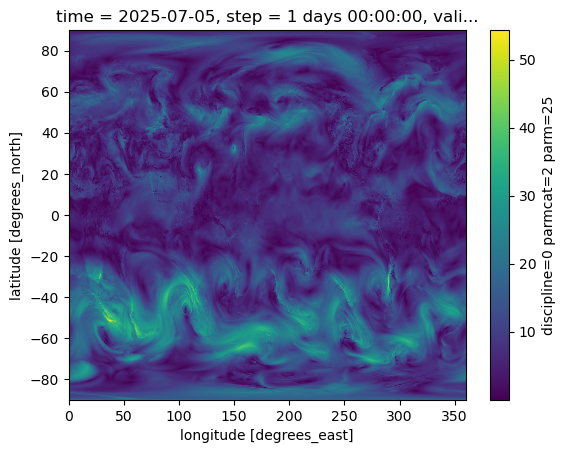

In [28]:
field = load_field_from_file(
    gfs_grib2_orig_file_path,
    parameter="shr(0-3000)"
)
field.plot()

## 字典格式

parameter 参数可以直接设置字典格式的 GRIB Key。

比如雷达反射率的编码如下：

```
discipline = 0
parameterCategory = 16
parameterNumber = 225
```

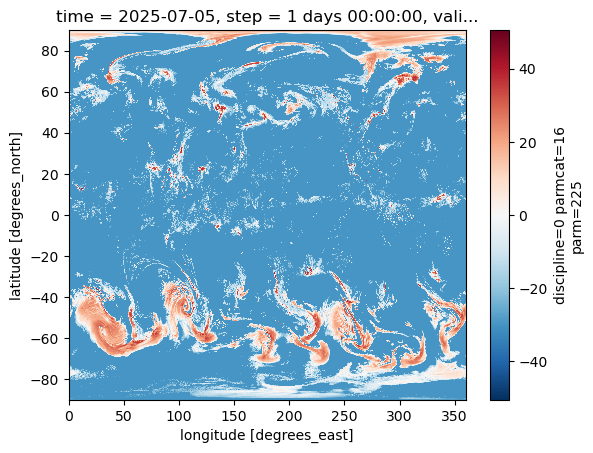

In [30]:
field = load_field_from_file(
    gfs_grib2_orig_file_path,
    parameter={
        "discipline": 0,
        "parameterCategory": 16,
        "parameterNumber": 225,
    },
    level_type="pl",
    level=850
)
field.plot()

```{note}
理论上 `parameter` 参数中可以设置任意 GRIB Key，不过建议将不同 GRIB Key 分散到不同的参数中。
`load_field_from_file` 函数也支持任意 GRIB key 作为关键字参数。
```